# Predicting Donation Projects Outcome Based on DonorsChoose.org Data

## Exploratory Data Analysis (EDA) Notebook

#### *Author: Kunyu He*
#### *University of Chicago CAPP'20*

### Executive Summary

In this notebook, I perform some initial data explorations on the preprocessed data, output of the [ETL notebook](https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/eec51c21-c64d-44be-b8ae-89d37dfc5cbd/view?projectid=fe8f6b6c-3d7e-4e63-bda2-d3d875f07abb&context=analytics) in data file `train.csv` on [IBM Cloud Object Storage](https://www.ibm.com/cloud/object-storage?S_PKG=AW&cm_mmc=Search_Google-_-Cloud_Cloud+Platform-_-WW_NA-_-ibm+cloud+object+storage_Exact_&cm_mmca1=000016GC&cm_mmca2=10007090&cm_mmca7=9021720&cm_mmca8=aud-311016886972:kwd-320507222281&cm_mmca9=_k_CjwKCAiAyfvhBRBsEiwAe2t_i1ZADYFVHn5C4dt5QQKrElVtqwWfFS08ZPk8slGBze9TyaULK38v3xoCIT0QAvD_BwE_k_&cm_mmca10=317209285666&cm_mmca11=e&mkwid=_k_CjwKCAiAyfvhBRBsEiwAe2t_i1ZADYFVHn5C4dt5QQKrElVtqwWfFS08ZPk8slGBze9TyaULK38v3xoCIT0QAvD_BwE_k_|1445|530573&cvosrc=ppc.google.ibm%20cloud%20object%20storage&cvo_campaign=000016GC&cvo_crid=317209285666&Matchtype=e&gclid=CjwKCAiAyfvhBRBsEiwAe2t_i1ZADYFVHn5C4dt5QQKrElVtqwWfFS08ZPk8slGBze9TyaULK38v3xoCIT0QAvD_BwE). I concentrate on how the proportion of fully funded projects, on average, changes across groups divided by several categorical variables and how some numerical variables differ across successful and failed donation projects. By EDA, I'm attempting to find those highly relevant to the outcome of donation projects.

Findings include:

* Total price requested, including and excluding optional tips, can be really strong signals for predicting project outcomes
* Word counts for need statement, short description and title of the projects differ greatly between successful and failed donation projects
* Number of items requsted, maximum, median, and minimum unit prices of the items requested can be good predictors of project outcomes
* Primary focus area of a project contains redundant information and can be represented by the project's primary focus subjects

### EDA Preparations

#### 1. Install and Import Packages

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import folium
import json
import numpy as np
import re

from matplotlib.font_manager import FontProperties
from urllib import request
from collections import Counter

#### 2. Load Data

Use the chunks below to list the data assets in my IBM Cloud Object Storage linked to this project. As it includes my credentials, the code is hidden from unauthorized viewers.

In [8]:
# The code was removed by Watson Studio for sharing.

In [6]:
project.get_files()

[{'asset_id': '7a2d8b2c-65c5-4258-8605-b95653bd30c5',
  'name': 'Donation-Projects-Outcome-Prediction.data.test.csv'},
 {'asset_id': 'f5450447-79fb-4b53-b646-5fbb9a220a8f',
  'name': 'Donation-Projects-Outcome-Prediction.data.train.csv'},
 {'asset_id': 'b6920713-693a-454e-855f-a24c95efd8ce',
  'name': 'Donation-Projects-Outcome-Prediction.data.projects.csv'},
 {'asset_id': '9b1c8961-1564-41a7-8402-89fded8d7e21',
  'name': 'Donation-Projects-Outcome-Prediction.data.outcomes.csv'},
 {'asset_id': '42bb6e53-4a3c-48f5-bcfb-5a7ab6b4461c',
  'name': 'Donation-Projects-Outcome-Prediction.data.resources.csv'},
 {'asset_id': '260878e4-a8c3-4c74-8070-48813214e8b2',
  'name': 'Donation-Projects-Outcome-Prediction.data.essays.csv'}]

 Load data into the environment.

In [7]:
train = pd.read_csv(project.get_file('Donation-Projects-Outcome-Prediction.data.train.csv'))

#### 3. Global Parameters

Set global parameters for better visualization.

In [9]:
%matplotlib inline

title = FontProperties()
title.set_family('serif')
title.set_size(14)
title.set_weight("semibold")

axis = FontProperties()
axis.set_family('serif')
axis.set_size(12)
axis.set_weight("roman")

ticks = FontProperties()
ticks.set_family('serif')
ticks.set_size(10)

plt.rcParams['figure.figsize'] = [12, 8]

RED_SQUARE = dict(markerfacecolor='r', marker='s')
GREEN_DIAMOND = dict(markerfacecolor='g', marker='D')

#### 4.  Auxiliary Functions

Define some auxiliary functions for data processing and plotting.

In [10]:
def count_by_outcome(df, col_name, by='fully_funded'):
    """
    Get count of fully-funded donation projects, failed projects, and the proportion of
    successful projects across categories defined by a column.
    
    Inputs:
        - df: (DataFrame)
        - col_name: (string) name of a categorical column to divide on in `df`
    
    Outputs:
        - (tuple) count of successful projects, failed projects, and proportion of successful ones
    """

    agg = df.groupby([col_name])[by].value_counts().unstack().fillna(0, inplace=False)

    success = agg[1].values
    failures = agg[0].values
    rates = np.append(success / (success + failures), failures / (success + failures))

    return success, failures, rates

In [11]:
def barplot_by_outcome(ax, df, col_name, by='fully_funded', plot_title=None, xlabel=None, ylabel=None,
                       xticks=[], xtick_labels=[], xtick_rotation=None, legend_loc="best"):
    """
    Make a barplot of counts of project against a categorical variable, with separate bars representing
    different outcomes, and numbers annotated at the top of the bars as proportions in the certain level.
    
    Inputs:
        - ax: (matplotlib Axes) axes (subplot) to plot on
        - df: (Pandas DataFrame)
        - col_name: (string) name of a categorical column to divide on in `df`
    
    Outputs:
        None
    """

    if not len(xtick_labels):
        xtick_labels = list(df.groupby([col_name])[by].value_counts().index.levels[0])    
    if not len(xticks):
        xticks = np.arange(len(xtick_labels))
        
    success, failures, rates = count_by_outcome(df, col_name)
    
    # plotting
    bar_width = 0.35
    
    ax.bar(xticks, success, bar_width, label="Fully Funded", edgecolor=["black"] * len(xticks))
    ax.bar(xticks + bar_width, failures, bar_width, label="Not Fully Funded", edgecolor=["black"] * len(xticks))
    
    ax.set_xlabel(xlabel, fontproperties=axis)
    ax.set_ylabel(ylabel, fontproperties=axis)
    ax.set_title(plot_title, fontproperties=title)

    ax.set_xticks(xticks + bar_width / 2)
    ax.set_xticklabels(xtick_labels, fontproperties=ticks, rotation=xtick_rotation)
    
    ax.legend(loc=legend_loc, frameon=True, fontsize="large")
    
    # annotating
    rects = ax.patches
    i = 0
    for rect in rects:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        label = "{:.1f}%".format(rates[i]*100)
        ax.annotate(label, (x_value, y_value), xytext=(0, 5), textcoords="offset points",
                    ha='center', va='bottom', fontproperties=ticks)
        i +=1

In [12]:
def boxplot_by_outcome(ax, df, col_name, by='fully_funded', constraint=None, plot_title=None,
                       xlabel=None, ylabel=None, title_format=axis, out_marker=RED_SQUARE,
                       xtick_labels=["Not Fully Funded", "Fully Funded"]):
    """
    Make a boxplot of certain numerical variable against a categorical variable, under constraint on the range of
    numerical variable if defined.
    
    Inputs:
        - ax: (matplotlib Axes) axes (subplot) to plot on
        - df: (Pandas DataFrame)
        - col_name: (string) name of a numerical column in `df`
        - by: (string) name of a categorical column to divide on in `df`
        - constraint: (float) for better visualization
    
    Outputs:
        None
    """

    if constraint:
        df = df[df[col_name] < constraint]

    df.boxplot(col_name, by=by, flierprops=out_marker, ax=ax)

    ax.set_title(plot_title, fontproperties=title_format)
    ax.set_xlabel(xlabel, fontproperties=axis)
    ax.set_ylabel(ylabel, fontproperties=axis)
    ax.set_xticklabels(xtick_labels, fontproperties=ticks)

    ax.grid(False)

In [13]:
def line_plot(ax, df, col_name, by='fully_funded', xtick_labels=[], xtick_rotation=None, plot_title=None,
              title_format=axis, xlabel=None, ylabel=None, legend_loc="best", percent_y=False):
    """
    Make a line plot of proportion of fully funded projects across levels divided by a categorical variable.
    
    Inputs:
        - ax: (matplotlib Axes) axes (subplot) to plot on
        - df: (Pandas DataFrame)
        - col_name: (string) name of a numerical column in `df`
        - by: (string) name of a categorical column to divide on in `df`
        - constraint: (float) for better visualization
        - percent_y: (bool) whether to display ticks labels on y-axis in percentage format
        
    Outputs:
        None
    """

    if not len(xtick_labels):
        xtick_labels = list(df.groupby([col_name])[by].value_counts().index.levels[0])
    
    success, failures, rates = count_by_outcome(df, col_name)
    rates = pd.DataFrame(rates[:int(len(rates)/2)], index=xtick_labels)
    rates.columns = [ylabel]

    rates.plot(kind="line", ax=ax, label=xlabel)
    
    ax.set_title(plot_title, fontproperties=title_format)
    ax.set_xlabel(xlabel, fontproperties=axis)
    ax.set_ylabel(ylabel, fontproperties=axis)
    
    ax.set_xticks(np.arange(len(xtick_labels)))
    ax.set_xticklabels(xtick_labels, fontproperties=ticks, rotation=xtick_rotation)
    
    if percent_y:
        rates = ax.get_yticks()
        ax.set_yticklabels(['{:,.0%}'.format(rate) for rate in rates], fontdict={'fontsize': 10})
        ax.get_xaxis().set_tick_params(direction='in', length=5)
    
    ax.legend(loc=legend_loc, frameon=True, fontsize="large")

### Exploratory Data Analysis

#### 1. Project counts by state

Create a choropleth map of counts of projects **(on log scale)** by states below.

In [14]:
url = "https://github.com/python-visualization/folium/raw/master/examples/data/us-states.json"
response = request.urlopen(url)
us_state = json.loads(response.read().decode())

In [15]:
counts_by_state = pd.DataFrame(train.school_state.value_counts()).reset_index()
counts_by_state.columns = ['State', 'Counts']
counts_by_state.Counts = np.log(counts_by_state.Counts)

In [16]:
counts = folium.Map(location=[37.8, -96], zoom_start=3.5)
folium.Choropleth(geo_data=us_state, data=counts_by_state, columns=['State', 'Counts'], key_on='feature.id',
                  fill_color="YlOrRd", fill_opacity=0.8, line_opacity=0.2,
                  legend_name="Project Counts by State (on Log scale)").add_to(counts)

counts

We can see that **California, New York, North Carolina, Illinois, Texas** are the states with highest numbers of projects across the US.

#### 2. Project outcome by teacher prefix

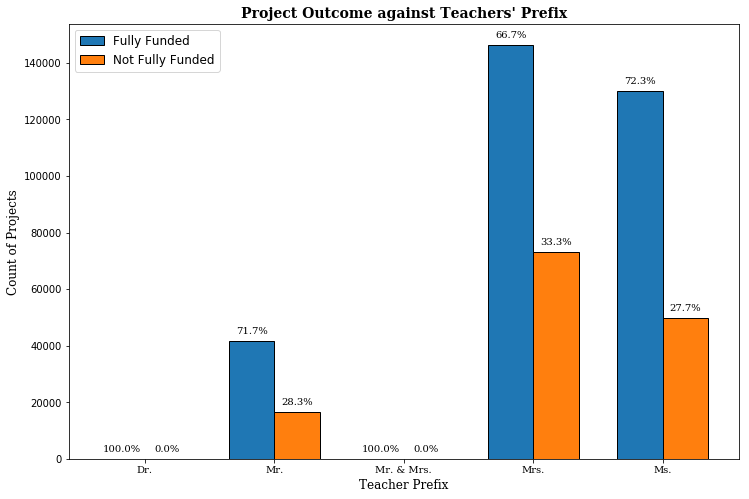

In [17]:
fig, ax = plt.subplots()
barplot_by_outcome(ax, train, 'teacher_prefix', xlabel="Teacher Prefix", ylabel="Count of Projects",
                   plot_title="Project Outcome against Teachers' Prefix", legend_loc="upper left")
plt.show()

Note that most of the projects are proposed by females (with `Mrs.` or `Ms.` prefix). Fully funded rates of projects proposed by teacher with **`Dr.` and `Mr. & Mrs.` are both 100%**, which is much higher than those of the other three categories.

#### 3. Project outcome by primary focus subject and area

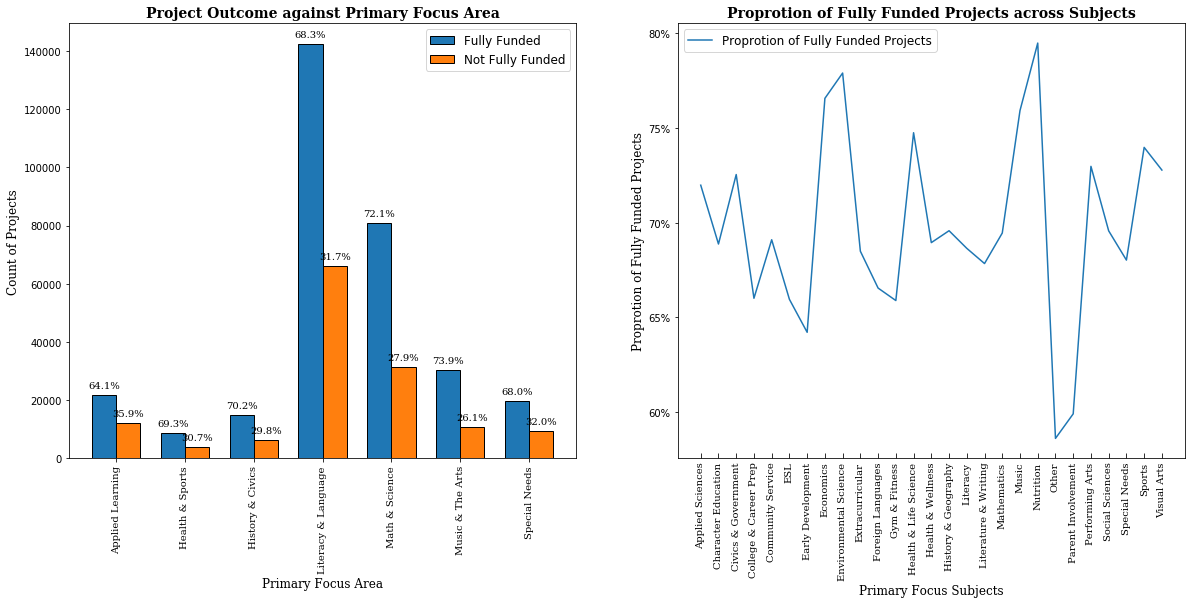

In [18]:
fig = plt.figure(figsize=[20, 8])
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

barplot_by_outcome(ax0, train, 'primary_focus_area', xlabel="Primary Focus Area", ylabel="Count of Projects",
                   plot_title="Project Outcome against Primary Focus Area", xtick_rotation="vertical")

line_plot(ax1, train, 'primary_focus_subject', xtick_rotation="vertical",
          plot_title="Proprotion of Fully Funded Projects across Subjects", title_format=title,
          xlabel="Primary Focus Subjects", ylabel="Proprotion of Fully Funded Projects", legend_loc="upper left",
          percent_y=True)

plt.show()

On the left panel, we can see that count of projects focused on `Literacy & Language` is the highest. Rate of getting fully funded is also different across areas, **`Music & The Arts`, `Math & Science`, and `History& Civics` projects have highest successful rate, while that of `Applied Learning` is the lowest.**

On the right, we can see the proportion of successful projects varies across promary focus subjects. **Sujects `Economics`, `Environmental Science`, `Music` and `Nutrition` have highest fully funded rates.**

**Since `primary_focus_area` is a collection of `primary_focus_subjects`, we should use the latter only to prevent information loss and multicollinearity.**

#### 4. Project outcome by type of resource and total price

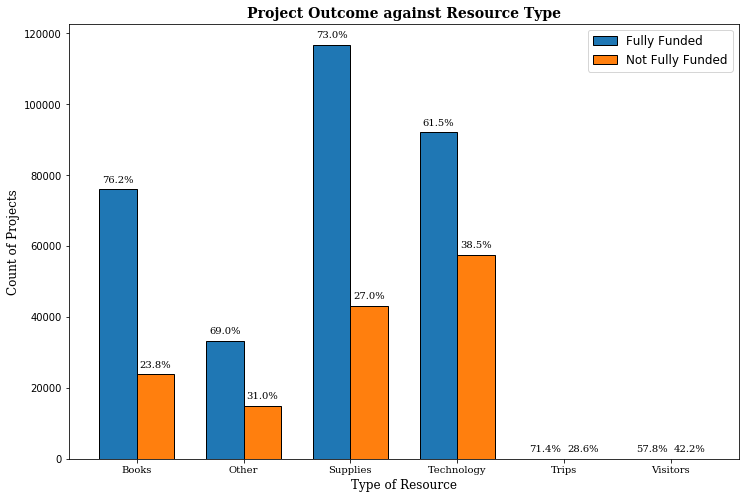

In [19]:
fig, ax = plt.subplots()
barplot_by_outcome(ax, train, 'resource_type', xlabel="Type of Resource",
                   ylabel="Count of Projects", plot_title="Project Outcome against Resource Type")
plt.show()

We observe that the most popular types of resource include `Supplies`, `Technology`, and `Books`. Meanwhile, **proportion of fully funded projects is much higher** in research category of **`Books` and `Supplies`.**

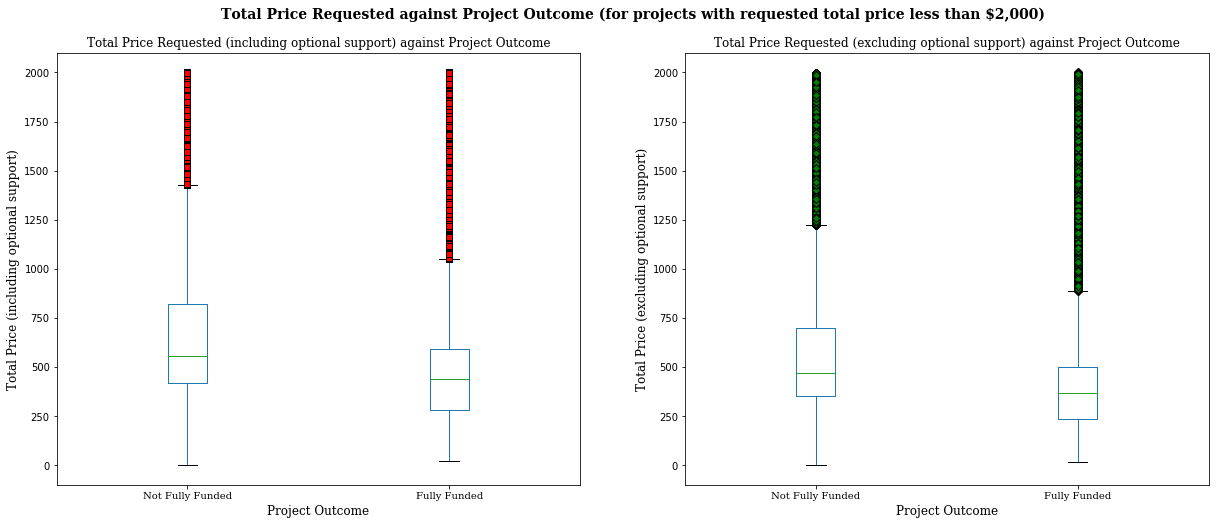

In [20]:
fig = plt.figure(figsize=[20, 8])
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

boxplot_by_outcome(ax0, train, 'total_price_including_optional_support', constraint=2000,
                   plot_title="Total Price Requested (including optional support) against Project Outcome",
                   xlabel="Project Outcome", ylabel="Total Price (including optional support)")

boxplot_by_outcome(ax1, train, 'total_price_excluding_optional_support', constraint=2000,
                   plot_title="Total Price Requested (excluding optional support) against Project Outcome",
                   xlabel="Project Outcome", ylabel="Total Price (excluding optional support)",
                   out_marker=GREEN_DIAMOND)

fig.suptitle(
    'Total Price Requested against Project Outcome (for projects with requested total price less than $2,000)',
    fontproperties=title)
plt.show()

With or without optional support, **we find that fully funded projects have lower total price requested, on average.**

#### 4. Project outcome by grade and povelty level

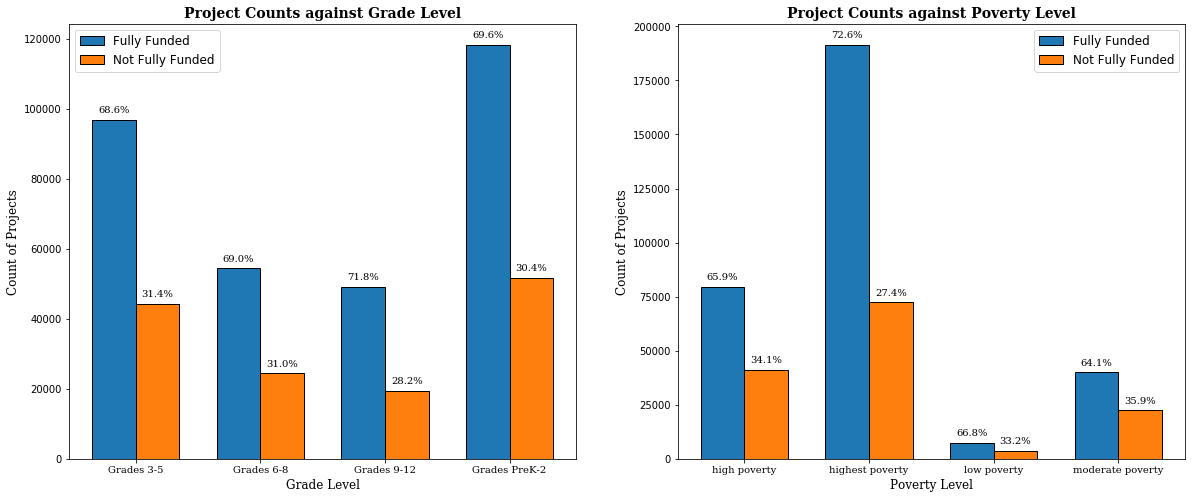

In [21]:
fig = plt.figure(figsize=[20, 8])
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

barplot_by_outcome(ax0, train, 'grade_level', xlabel="Grade Level", ylabel="Count of Projects",
                   plot_title="Project Counts against Grade Level")

barplot_by_outcome(ax1, train, 'poverty_level', xlabel="Poverty Level", ylabel="Count of Projects",
                   plot_title="Project Counts against Poverty Level")

plt.show()

On the left plot, we can see that `Grades PreK-2` is the most popular. **Proportions of fully funded projects across grade level are not significantly different, though.**

As expected, requesting donations for schools with the **`highest poverty` (65%+) is the most popular and is with the highest success rate.**

#### 5. Project outcome by week of day, month of year and year

Create a side-by-side barplot to show the total count of projects on each day of week, colored by whether the project is fully funded or not.

In [22]:
weekdays = np.arange(7)
weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

day_of_week = train.date_posted.dt.weekday.replace(to_replace=weekdays, value=weekday_labels, inplace=False)
train['day_of_week'] = pd.Categorical(day_of_week, categories=weekday_labels)
train['month_of_year'] = pd.Categorical(train.date_posted.dt.month)
train['year'] = pd.Categorical(train.date_posted.dt.year)

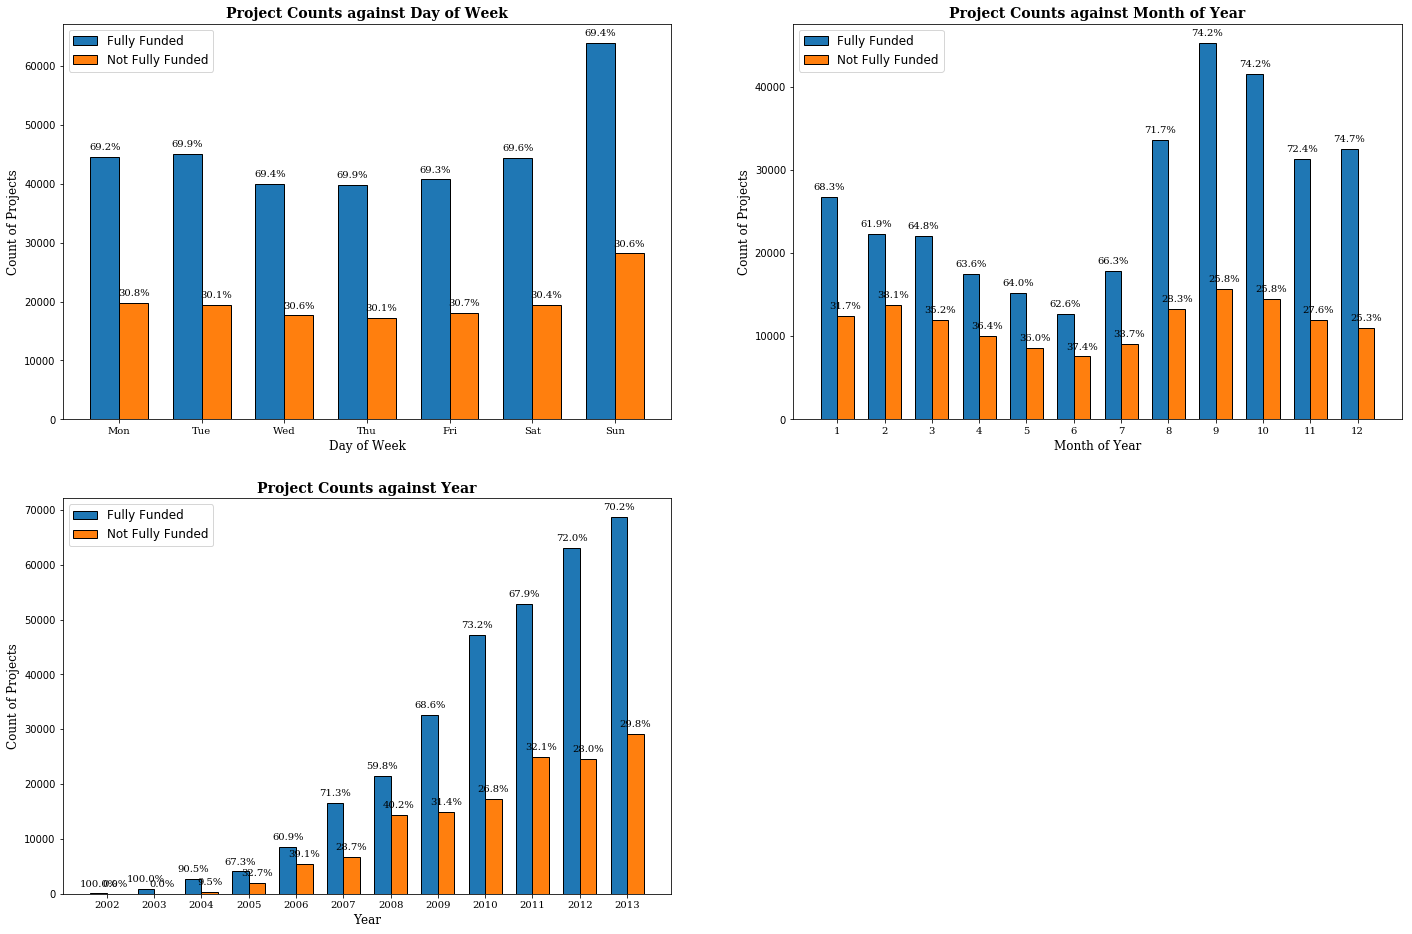

In [23]:
fig = plt.figure(figsize=[24, 16])
ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)

barplot_by_outcome(ax0, train, 'day_of_week', xticks=weekdays, xtick_labels=weekday_labels,
                   xlabel="Day of Week", ylabel="Count of Projects", plot_title="Project Counts against Day of Week")

barplot_by_outcome(ax1, train, 'month_of_year', xlabel="Month of Year", ylabel="Count of Projects",
                   plot_title="Project Counts against Month of Year", legend_loc="upper left")

barplot_by_outcome(ax2, train, 'year', xlabel="Year", ylabel="Count of Projects",
                   plot_title="Project Counts against Year")

plt.show()

In the upper left plot, we observe that the total count of projects posted is basically not changing from `Monday thru Saturday`, but is relatively higher on `Sundays`. However, **the proportion of fully funded projects is nearly invariant across days of a week.**

On the contrary, in the upper right panel here we observe that the **rate of fully funded projects are much higher (by nearly 8% on average) over the year from `August to December`, compared with the period from `January to July`.** Month of year could be a good predictor for whether a project would succeed.

At last, total counts of projects posted are rapidly increasing during the period of 2002-2013. However, **in early stages (2002-2004), almost all projects posted got fully funded. The rate varies in the years following.**

#### 6. Project outcome by number of students reached and great chat

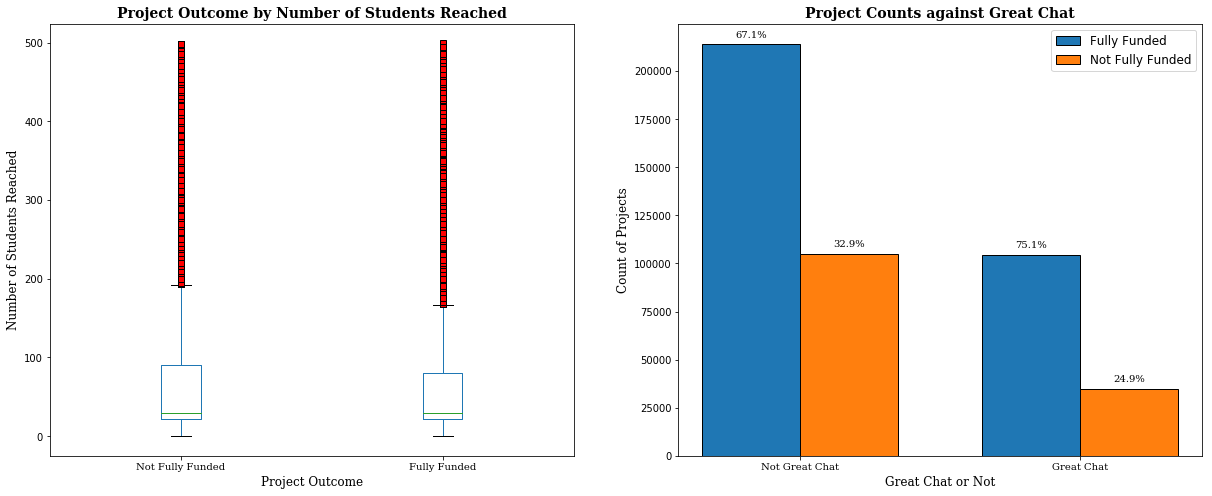

In [24]:
fig = plt.figure(figsize=[20, 8])
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

boxplot_by_outcome(ax0, train, 'students_reached', constraint=500,
                   plot_title="Project Outcome by Number of Students Reached",
                   xlabel="Project Outcome", ylabel="Number of Students Reached", title_format=title)

barplot_by_outcome(ax1, train, 'great_chat', xlabel="Great Chat or Not", ylabel="Count of Projects",
                   plot_title="Project Counts against Great Chat", xtick_labels=["Not Great Chat", "Great Chat"])

fig.suptitle('')
plt.show()

Sprisingly, we observe fully funded projects reach less students, on average.

As expected, projects with great chats have higher rate of getting fully funded, on average.

#### 7. Project outcome by word counts

First parse `title` column from `essays` with original title strings into a column with lists of individual lower-case words.

In [25]:
def parse(df, col_name, pattern='[\W_]+'):
    pattern = re.compile(pattern)
    return df[col_name].str.lower().str.split().map(lambda row: \
                                                    list(map(lambda string: pattern.sub("", string), row)))

Then count the most frequent words in project titles. **Here we only keep meaningful words (Nouns and Verbs).**

In [26]:
train['parsed_title'] = parse(train, 'title')
results = Counter()
count = train.parsed_title.map(results.update)

In [27]:
for top in results.most_common(50):
    if top[0] in ["the", "for", "to", "a", "and", "in", "with", "our", "of", "",
                  "we", "my", "is", "us", "on", "i", "it"]:
        results[top[0]] = 0

results.most_common(10)

[('reading', 28319),
 ('learning', 26676),
 ('help', 25617),
 ('books', 22163),
 ('students', 21762),
 ('need', 20729),
 ('classroom', 20553),
 ('math', 19410),
 ('technology', 18900),
 ('read', 16386)]

So the ten most frequent words in project titles are: **reading, learning, help, books, students, need, classroom, math, technology and read.**

Create features measuring the length of titles, need statements, short descriptions, and essays by word.

In [28]:
train['title_length'] = train.title.str.len()
train['need_statement_length'] = train.need_statement.str.len()
train['short_description_length'] = train.short_description.str.len()
train['essay_length'] = train.essay.str.len()

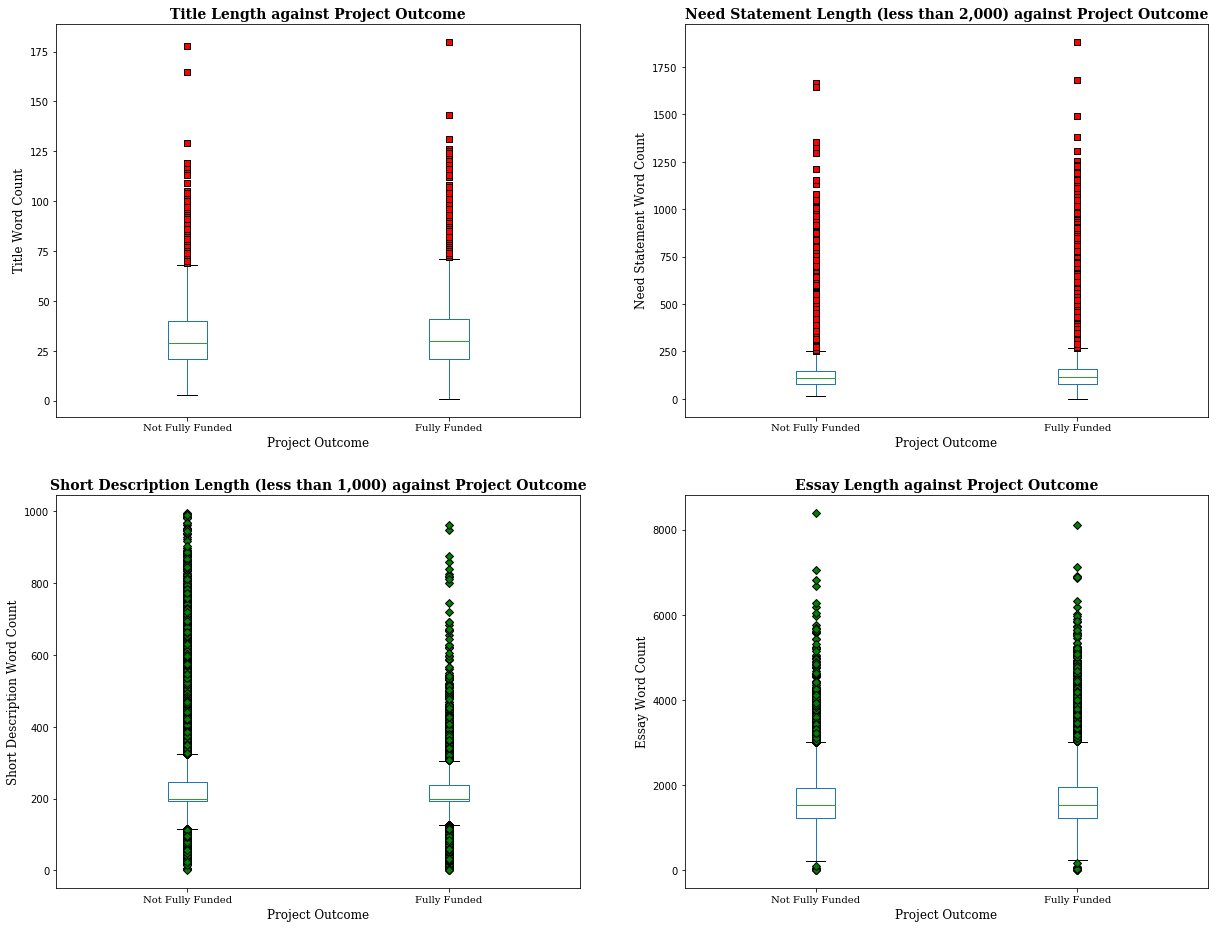

In [29]:
fig = plt.figure(figsize=[20, 16])
ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)

boxplot_by_outcome(ax0, train, 'title_length', xlabel='Project Outcome', ylabel='Title Word Count',
                   plot_title="Title Length against Project Outcome", title_format=title)

boxplot_by_outcome(ax1, train, 'need_statement_length', xlabel="Project Outcome", ylabel="Need Statement Word Count",
                   plot_title="Need Statement Length (less than 2,000) against Project Outcome",
                   title_format=title, constraint=2000)

boxplot_by_outcome(ax2, train, 'short_description_length',
                   xlabel="Project Outcome",ylabel="Short Description Word Count",
                   plot_title='Short Description Length (less than 1,000) against Project Outcome',
                   title_format=title, constraint=1000, out_marker=GREEN_DIAMOND)

boxplot_by_outcome(ax3, train, 'essay_length', xlabel="Project Outcome", ylabel="Essay Word Count",
                   plot_title="Essay Length against Project Outcome",
                   title_format=title, out_marker=GREEN_DIAMOND)

fig.suptitle('')
plt.show()

Seems that projects with **longer titles, longer need statements, and shorter short descriptions are more likely to get fully funded**, on average.

#### 8. Project outcome by resources statistics

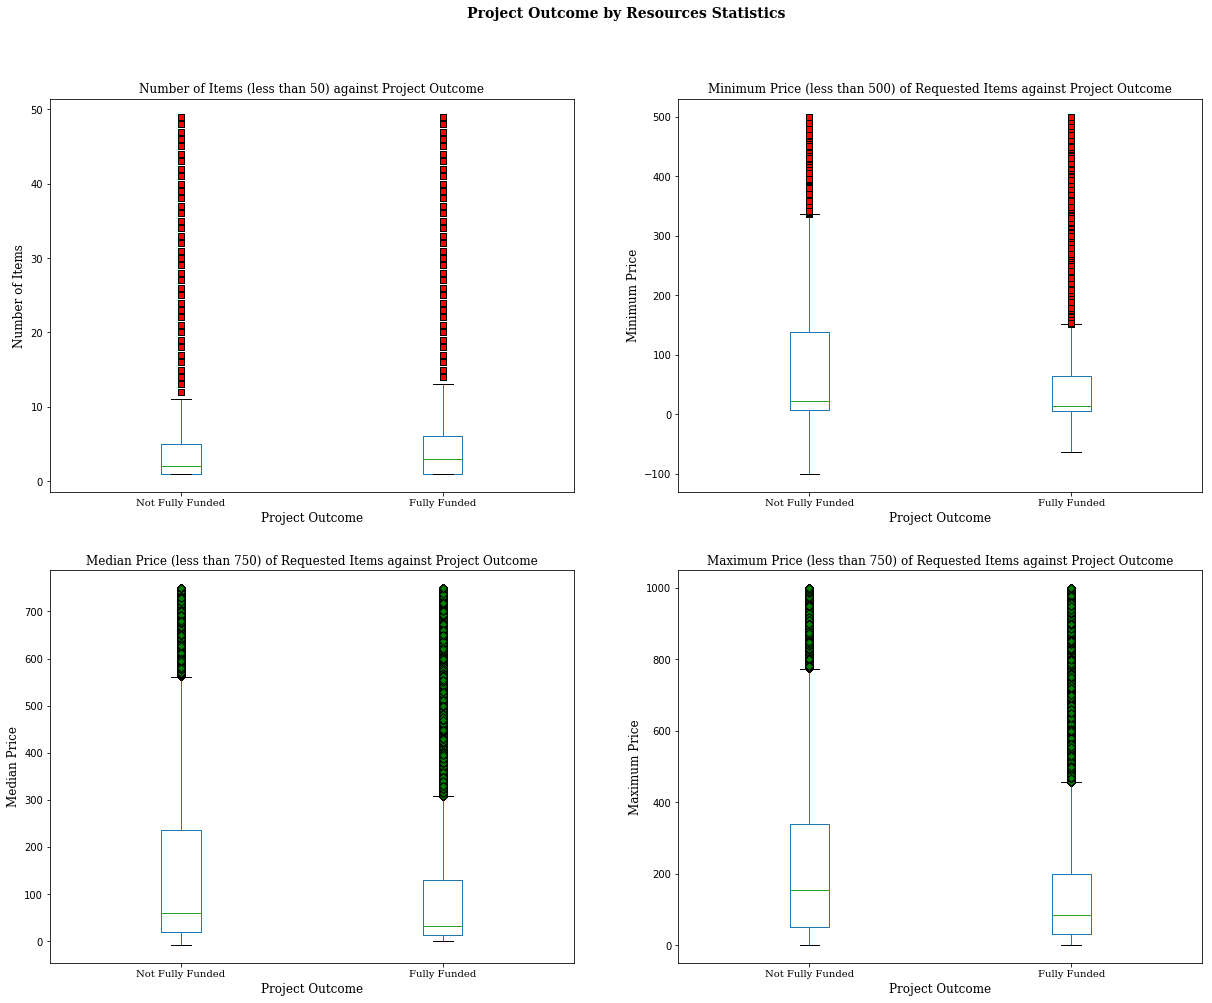

In [30]:
fig = plt.figure(figsize=[20, 16])
ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)

boxplot_by_outcome(ax0, train, 'number_of_items', xlabel="Project Outcome", ylabel="Number of Items",
                   plot_title="Number of Items (less than 50) against Project Outcome", constraint=50)

boxplot_by_outcome(ax1, train, 'min_price_items', xlabel="Project Outcome", ylabel="Minimum Price",
                   plot_title="Minimum Price (less than 500) of Requested Items against Project Outcome",
                   constraint=500)

boxplot_by_outcome(ax2, train, 'median_price_items', xlabel="Project Outcome", ylabel="Median Price",
                   plot_title="Median Price (less than 750) of Requested Items against Project Outcome",
                   constraint=750, out_marker=GREEN_DIAMOND)

boxplot_by_outcome(ax3, train, 'max_price_items', xlabel="Project Outcome", ylabel="Maximum Price",
                   plot_title="Maximum Price (less than 750) of Requested Items against Project Outcome",
                   constraint=1000, out_marker=GREEN_DIAMOND)

fig.suptitle('Project Outcome by Resources Statistics', fontproperties=title)
plt.show()

We observe that projects with **higher number of items requested, lower minimum, median and maximum price of requested items** are more likely to get fully funded. The differences are quiet significant.